Importing Libraries and reading files

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, pearsonr
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv("data.csv", low_memory=False)
print("Shape:", data.shape)
data.head()

Shape: (1058297, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,1
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,2
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,3
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,4
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,5


Preprocessing

In [9]:
def preprocess_data(df):

    for col in ['Sales', 'Customers']:
        if col in df.columns:
            df = df[df[col] > 0]
    
    for col in df.columns:
        if df[col].dtype.kind in 'biufc':  
            df[col] = df[col].fillna(df[col].median())
        else:  
            df[col] = df[col].fillna('None')
    
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    
    categorical_cols = [col for col in ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'] if col in df.columns]
    if categorical_cols:
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    if 'Sales' in df.columns:
        z = np.abs(stats.zscore(df['Sales']))
        df = df[z < 3]
    
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    
    return df
cleaned_data = preprocess_data(data)
cleaned_data.to_csv("cleaned_data.csv", index=False)
print("Shape:", cleaned_data.shape)
cleaned_data.head()


Shape: (830895, 17)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Id,Year,Month,Week,Day,IsWeekend,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,4,2015-07-31,5263.0,555.0,1.0,1,1,1,2015,7,31,31,0,False,False,False
1,2,4,2015-07-31,6064.0,625.0,1.0,1,1,2,2015,7,31,31,0,False,False,False
2,3,4,2015-07-31,8314.0,821.0,1.0,1,1,3,2015,7,31,31,0,False,False,False
3,4,4,2015-07-31,13995.0,1498.0,1.0,1,1,4,2015,7,31,31,0,False,False,False
4,5,4,2015-07-31,4822.0,559.0,1.0,1,1,5,2015,7,31,31,0,False,False,False


EDA: Exploratory Data Analysis

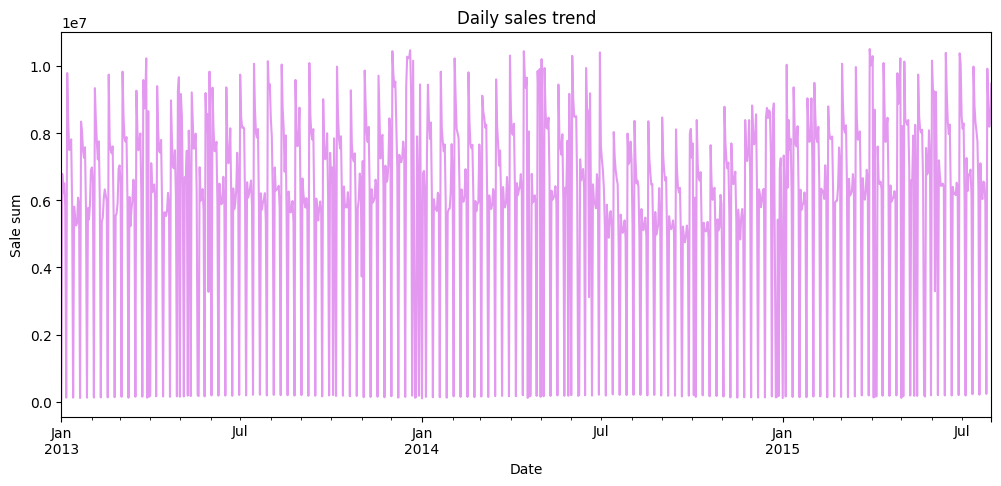

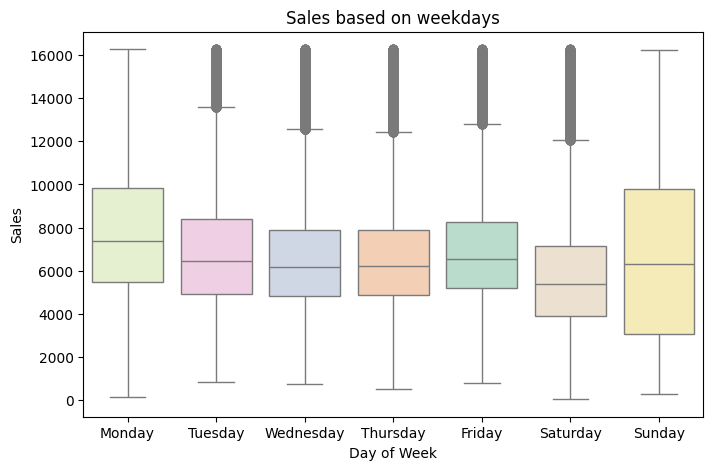

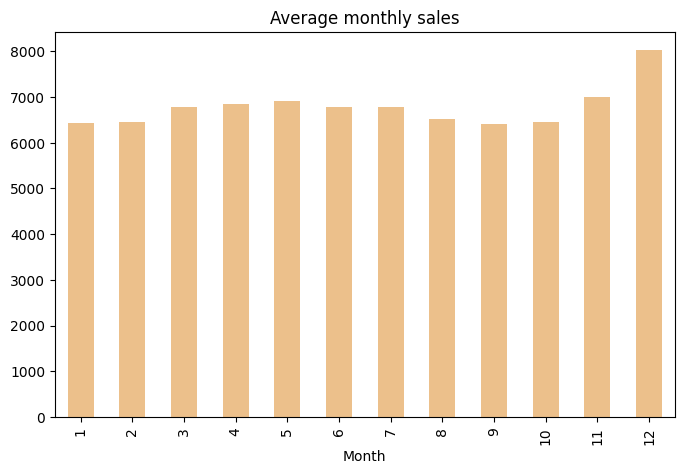

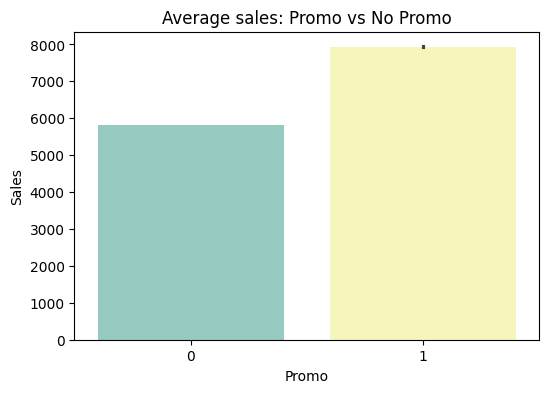

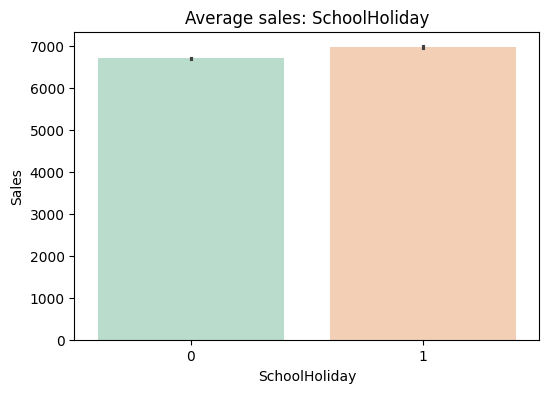

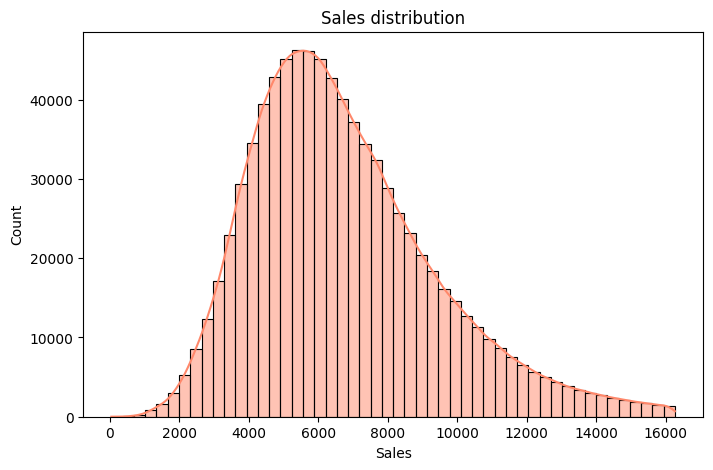

In [10]:
full_data = pd.read_csv("cleaned_data.csv", parse_dates=["Date"])
if 'Sales' in full_data.columns:

    if 'Date' in full_data.columns:
        plt.figure(figsize=(12,5))
        full_data.groupby('Date')['Sales'].sum().plot(color="#e499f0")
        plt.title('Daily sales trend')
        plt.ylabel('Sale sum')
        plt.show()

    if 'DayOfWeek' in full_data.columns:
        full_data['DayOfWeekName'] = full_data['DayOfWeek'].map({
            0: 'Monday',
            1: 'Tuesday',
            2: 'Wednesday',
            3: 'Thursday',
            4: 'Friday',
            5: 'Saturday',
            6: 'Sunday'
        })

    plt.figure(figsize=(8,5))
    sns.boxplot(x='DayOfWeekName', y='Sales', data=full_data,
                order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='Pastel2' , hue='DayOfWeekName', legend=False)
    plt.title('Sales based on weekdays')
    plt.xlabel('Day of Week')
    plt.show()

    if 'Month' in full_data.columns:
        plt.figure(figsize=(8,5))
        full_data.groupby('Month')['Sales'].mean().plot(kind='bar',color="#ecc08b")
        plt.title('Average monthly sales')
        plt.show()

    if 'Promo' in full_data.columns:
        plt.figure(figsize=(6,4))
        sns.barplot(x='Promo', y='Sales', data=full_data, palette='Set3', hue='Promo', legend=False)
        plt.title('Average sales: Promo vs No Promo')
        plt.show()

    if 'SchoolHoliday' in full_data.columns:
        plt.figure(figsize=(6,4))
        sns.barplot(x='SchoolHoliday', y='Sales', data=full_data, palette='Pastel2', hue='SchoolHoliday', legend=False)
        plt.title('Average sales: SchoolHoliday')
        plt.show()

    plt.figure(figsize=(8,5))
    sns.histplot(full_data['Sales'], bins=50, kde=True, color="#ff886b")
    plt.title('Sales distribution')
    plt.show()

else:
    print("Sales not found")


Tahlil Amari

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Id,Year,Month,Week,Day,IsWeekend
count,830895.000000,830895.000000,830895,830895.000000,830895.000000,830895.0,830895.000000,830895.000000,8.308950e+05,830895.000000,830895.000000,830895.000000,830895.000000,830895.000000
mean,558.091421,2.530687,2014-04-10 16:26:50.820139008,6755.018611,737.828911,1.0,0.442121,0.193068,5.089996e+05,2013.832064,5.832133,23.587382,15.844328,0.175739
min,1.000000,0.000000,2013-01-01 00:00:00,46.000000,8.000000,1.0,0.000000,0.000000,1.000000e+00,2013.000000,1.000000,1.000000,1.000000,0.000000
25%,280.000000,1.000000,2013-08-16 00:00:00,4835.000000,517.000000,1.0,0.000000,0.000000,2.563955e+05,2013.000000,3.000000,11.000000,8.000000,0.000000
50%,558.000000,3.000000,2014-03-31 00:00:00,6319.000000,670.000000,1.0,0.000000,0.000000,5.105660e+05,2014.000000,6.000000,23.000000,16.000000,0.000000
75%,839.000000,4.000000,2014-12-10 00:00:00,8235.000000,879.000000,1.0,1.000000,0.000000,7.635965e+05,2014.000000,8.000000,35.000000,23.000000,0.000000
max,1115.000000,6.000000,2015-07-31 00:00:00,16267.000000,4582.000000,1.0,1.000000,1.000000,1.017191e+06,2015.000000,12.000000,52.000000,31.000000,1.000000
std,322.360199,1.719658,NaN,2666.058345,338.686958,0.0,0.496639,0.394706,2.938546e+05,0.777475,3.316651,14.355881,8.669770,0.380599


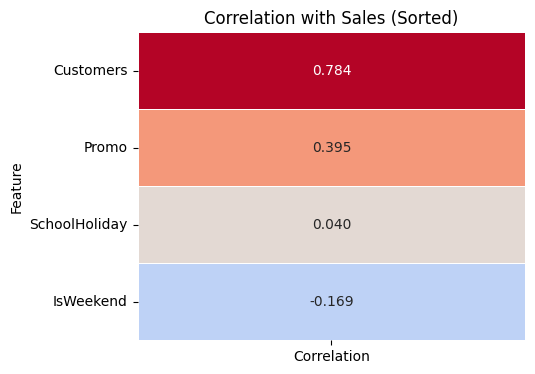

T-test (Promo vs No Promo): t=386.97, p=0.000e+00
T-test (SchoolHoliday vs Non): t=35.95, p=2.879e-282


In [11]:
display(full_data.describe())
key_features = [
    'Customers',
    'IsWeekend',
    'Promo',
    'SchoolHoliday',
    'SalesPerCustomer'
]

corr_values = {}
for col in key_features:
    if col in full_data.columns:
        valid_data = full_data[['Sales', col]].replace([np.inf, -np.inf], np.nan).dropna()
        if not valid_data.empty:
            corr_val, _ = pearsonr(valid_data['Sales'], valid_data[col])
            corr_values[col] = corr_val
        else:
            corr_values[col] = np.nan

corr_df = pd.DataFrame(list(corr_values.items()), columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(5, 4))
sns.heatmap(
    corr_df.set_index('Feature'),
    annot=True, cmap='coolwarm', center=0, fmt=".3f",
    linewidths=0.5, cbar=False
)
plt.title('Correlation with Sales (Sorted)')
plt.show()


if 'Promo' in full_data.columns:
    promo_sales = full_data[full_data['Promo'] == 1]['Sales']
    no_promo_sales = full_data[full_data['Promo'] == 0]['Sales']
    t_stat, p_val = ttest_ind(promo_sales, no_promo_sales, equal_var=False)
    print(f"T-test (Promo vs No Promo): t={t_stat:.2f}, p={p_val:.3e}")

if 'SchoolHoliday' in full_data.columns:
    sch_sales = full_data[full_data['SchoolHoliday'] == 1]['Sales']
    no_sch_sales = full_data[full_data['SchoolHoliday'] == 0]['Sales']
    t_stat_sch, p_val_sch = ttest_ind(sch_sales, no_sch_sales, equal_var=False)
    print(f"T-test (SchoolHoliday vs Non): t={t_stat_sch:.2f}, p={p_val_sch:.3e}")

storetype_cols = [col for col in full_data.columns if "StoreType_" in col]
if len(storetype_cols) > 1:
    sales_groups = [full_data[full_data[col] == 1]['Sales'] for col in storetype_cols]
    f_stat, p_type = f_oneway(*sales_groups)
    print(f"ANOVA (Sales by StoreType): F={f_stat:.2f}, p={p_type:.3e}")


Building a model

C:\Users\ELECOMP\AppData\Local\Temp\ipykernel_25956\1317539118.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['Sales'].shift(1) / g['Customers'].shift(1))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 16
[LightGBM] [Info] Start training from score 6771.311550
Best params: {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 800, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1651
[LightGBM] [Info] Number of data points in the train set: 558211, number of used features: 17
[LightGBM] [Info] Start training from score 6770.185638
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:


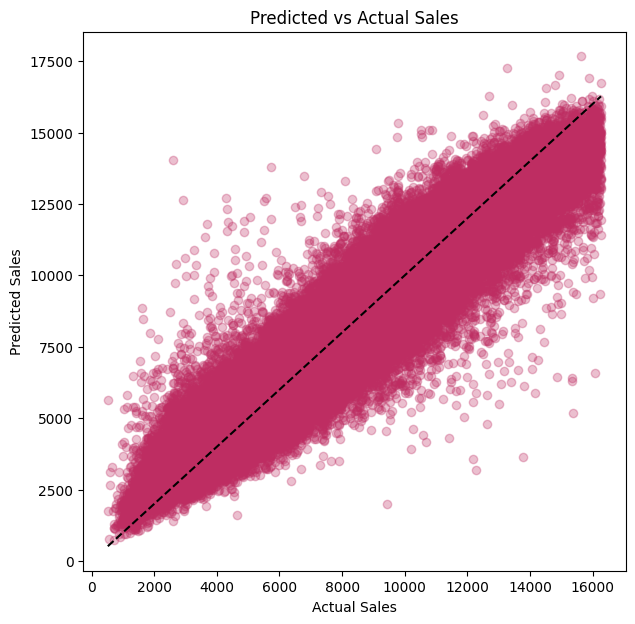

In [12]:
df = pd.read_csv("cleaned_data.csv", parse_dates=["Date"])

df = df.sort_values(["Store", "Date"]).reset_index(drop=True)

df["Sales_lag_7"] = df.groupby("Store")["Sales"].shift(7)
df["Sales_lag_14"] = df.groupby("Store")["Sales"].shift(14)
df["Sales_roll_mean_7"] = df.groupby("Store")["Sales"].shift(1).rolling(window=7).mean()
df["Sales_roll_mean_30"] = df.groupby("Store")["Sales"].shift(1).rolling(window=30).mean()
df['SalesPerCustomer'] = (
    df.groupby('Store')
      .apply(lambda g: g['Sales'].shift(1) / g['Customers'].shift(1))
      .reset_index(level=0, drop=True)
)

df = df.dropna().reset_index(drop=True)

if "Id" in df.columns:
    df = df.drop(columns=["Id"])

y = df["Sales"]
X = df.drop(["Sales", "Date", "Customers"], axis=1, errors="ignore")

sample_df = df.sample(n=100_000, random_state=42)
y_sample = sample_df["Sales"]
X_sample = sample_df.drop(["Sales", "Date", "Customers"], axis=1, errors="ignore")

param_dist = {
    "num_leaves": [31, 50, 70],
    "max_depth": [-1, 10, 20, 30],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

lgbm = LGBMRegressor(objective="regression", random_state=42)
rand_search = RandomizedSearchCV(
    lgbm, param_distributions=param_dist,
    n_iter=10, scoring="neg_root_mean_squared_error",
    cv=3, random_state=42, n_jobs=-1, verbose=0
)
rand_search.fit(X_sample, y_sample)
best_params = rand_search.best_params_
print("Best params:", best_params)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

final_model = LGBMRegressor(**best_params, objective="regression", random_state=42)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[early_stopping(50), log_evaluation(0)]
)

y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final RMSE: {rmse:.2f}")
print(f"Final MAE: {mae:.2f}")
print(f"Final R²: {r2:.4f}")

feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Top 7 Feature Importances:")
print(feat_df.head(7).to_string(index=False))

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3, color='#be2d62')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()
